In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
# import shap

import warnings
warnings.filterwarnings('ignore')

## Introuction/ Problem Statement

This project analyzes the Olist e-commerce dataset, a comprehensive dataset capturing customer df, product details, seller information, and delivery logistics from a multi-category online store in Brazil.

The main goal of this analysis is to understand consumer behavior and purchase patterns through detailed exploratory data analysis (EDA) and feature engineering. By categorizing sessions and examining key behavioral metrics, the project aims to:

- Identify distinct customer purchase behaviors and patterns

- Explore factors influencing order delivery times and order status

- Build predictive models to forecast outcomes such as delivery delays or order cancellations

- Interpret model results using SHAP analysis for actionable insights

- Provide business recommendations to optimize customer experience and operational efficiency

- The ultimate objective is to derive insights that support data-driven decisions for enhancing e-commerce performance and customer satisfaction.



## Data Overview/ Cleaning

In [2]:
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
products = pd.read_csv('dataset/olist_products_dataset.csv')
sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
categories = pd.read_csv('dataset/product_category_name_translation.csv')


In [3]:
# Merge orders with customers (on customer_id)
df = orders.merge(customers, on='customer_id', how='left')

# Merge with order_items (on order_id)
df = df.merge(order_items, on='order_id', how='left')

# Merge with products (on product_id)
df = df.merge(products, on='product_id', how='left')

# Merge with sellers (on seller_id)
df = df.merge(sellers, on='seller_id', how='left')

df = df.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

df = df.merge(categories, on='product_category_name', how='left')
df.drop('product_category_name', axis=1, inplace=True)


In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,review_score,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,4.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,4.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,5.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG,5.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP,5.0,stationery


In [5]:
df.shape

(114092, 30)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   order_status                   114092 non-null  object 
 3   order_purchase_timestamp       114092 non-null  object 
 4   order_approved_at              113930 non-null  object 
 5   order_delivered_carrier_date   112112 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  114092 non-null  object 
 8   customer_unique_id             114092 non-null  object 
 9   customer_zip_code_prefix       114092 non-null  int64  
 10  customer_city                  114092 non-null  object 
 11  customer_state                 114092 non-null  object 
 12  order_item_id                 

In [7]:
df.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'
}, inplace=True)


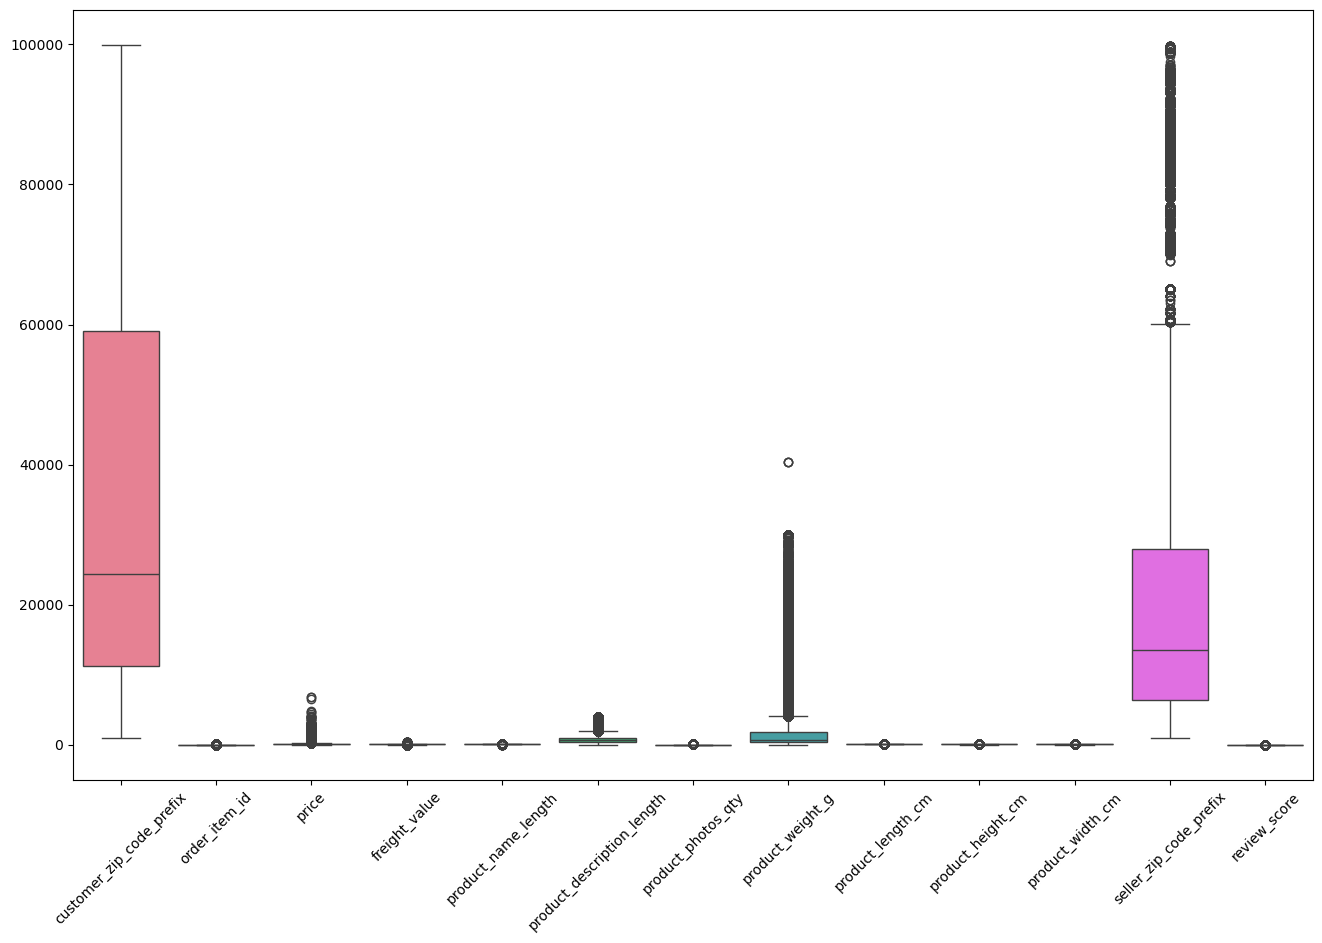

In [8]:
plt.figure(figsize=(16,10))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()

Observation: There are lots of outliers found from most of the variables, but they are all unique values so i wouldn't drop any of them.

In [9]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 162
order_delivered_carrier_date     1980
order_delivered_customer_date    3253
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     778
product_id                        778
seller_id                         778
shipping_limit_date               778
price                             778
freight_value                     778
product_name_length              2390
product_description_length       2390
product_photos_qty               2390
product_weight_g                  796
product_length_cm                 796
product_height_cm                 796
product_width_cm                  796
seller_zip_code_prefix            778
seller_city 

In [10]:
missing_values = [
    'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price',
    'freight_value', 'product_name_length', 'product_description_length', 'product_photos_qty', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score', 'product_category_name_english']

for col in missing_values:
    print(f"{col}: {df[col].unique()}")
    print("\n")    

order_approved_at: ['2017-10-02 11:07:15' '2018-07-26 03:24:27' '2018-08-08 08:55:23' ...
 '2017-08-27 15:04:16' '2018-01-08 21:36:21' '2018-03-09 11:20:28']


order_delivered_carrier_date: ['2017-10-04 19:55:00' '2018-07-26 14:31:00' '2018-08-08 13:50:00' ...
 '2017-08-28 20:52:26' '2018-01-12 15:35:03' '2018-03-09 22:11:59']


order_delivered_customer_date: ['2017-10-10 21:25:13' '2018-08-07 15:27:45' '2018-08-17 18:06:29' ...
 '2017-09-21 11:24:17' '2018-01-25 23:32:54' '2018-03-16 13:08:30']


order_item_id: [ 1.  2.  3.  4.  5.  6. nan  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]


product_id: ['87285b34884572647811a353c7ac498a' '595fac2a385ac33a80bd5114aec74eb8'
 'aa4383b373c6aca5d8797843e5594415' ... '3d2c44374ee42b3003a470f3e937a2ea'
 'ac35486adb7b02598c182c2ff2e05254' '006619bbed68b000c8ba3f8725d5409e']


seller_id: ['3504c0cb71d7fa48d967e0e4c94d59d9' '289cdb325fb7e7f891c38608bf9e0962'
 '4869f7a5dfa277a7dca6462dcf3b52b2' ... 'd263fa444c1504a75cbca5cc465f592a'


In [11]:
def preprocess(df):
    
    # Drop rows missing critical fields
    
    df = df.dropna(subset=[
        'order_approved_at', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 
        'price', 'freight_value', 'product_category_name_english', 'product_name_length', 
        'product_description_length', 'product_photos_qty'])
    
    # Impute product dimensions with median per category
    
    dims = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
    for col in dims:
        df[col] = df.groupby('product_category_name_english')[col].transform(lambda x: x.fillna(x.median()))
    
    # Convert date columns safely
    
    for col in ['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
    # New column 'delivery status'
    
    def delivery_status(row):
        if pd.isna(row['order_delivered_carrier_date']):
            return 'Failed'
        elif pd.isna(row['order_delivered_customer_date']) and not pd.isna(row['order_delivered_carrier_date']):
            return 'Carrier'
        else:
            return 'Completed'
        
    df['delivery_status'] = df.apply(delivery_status, axis=1)

    # New column: delivery_delay (NaN if not delivered)
    
    df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

    conditions = [
        df['delivery_delay'] > 0,
        df['delivery_delay'] == 0,
        df['delivery_delay'] < 0]

    choices = ['Violated', 'On time', 'Early delivery']
    df['sla_violation'] = np.select(conditions, choices, default=np.nan)

    # Mode imputation of review_score grouped by sla_violation (review_score mode 5 if no mode in sla_violation)
    
    df['review_score'] = (df.groupby('sla_violation')['review_score'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 5)))

    # Drop duplicates
    
    df.drop_duplicates()
    return df

In [12]:
df = preprocess(df)

In [13]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     1163
order_delivered_customer_date    2406
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_name_length                 0
product_description_length          0
product_photos_qty                  0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
seller_zip_code_prefix              0
seller_city 

Observation: I'll drop order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date' after EDA.

## EDA

In [14]:
print(df.groupby('delivery_status')['order_status'].value_counts())

delivery_status  order_status
Carrier          shipped           1169
                 canceled            68
                 delivered            7
Completed        delivered       109250
                 canceled             7
Failed           canceled           455
                 invoiced           352
                 processing         344
                 unavailable          7
                 approved             3
                 delivered            2
Name: count, dtype: int64


In [15]:
df = df[~((df['delivery_status'].isin(['Failed', 'Carrier'])) & (df['order_status'] == 'delivered'))]
df = df[~((df['delivery_status'] == 'Completed') & (df['order_status'] == 'canceled'))]

In [16]:
print(df.groupby('delivery_status')['order_status'].value_counts())


delivery_status  order_status
Carrier          shipped           1169
                 canceled            68
Completed        delivered       109250
Failed           canceled           455
                 invoiced           352
                 processing         344
                 unavailable          7
                 approved             3
Name: count, dtype: int64


Observation: Removed 'delivered' rows when the product hasn't been shipped to the carrier or failed. Also removed 'canceled' when the customer received the order already to avoid confusion.

In [18]:
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'], errors='coerce')

condition = (df['order_approved_at'] < df['order_delivered_carrier_date']) & (df['order_approved_at'] < df['order_delivered_customer_date'])

print(f"Rows before filtering: {len(df)}")
df = df[condition].copy()

print(f"Rows after filtering: {len(df[condition])}")

Rows before filtering: 111648
Rows after filtering: 107715


Observation: Removed the rows that were approved after delivered to either carrier and customer as it doesn't make sense.

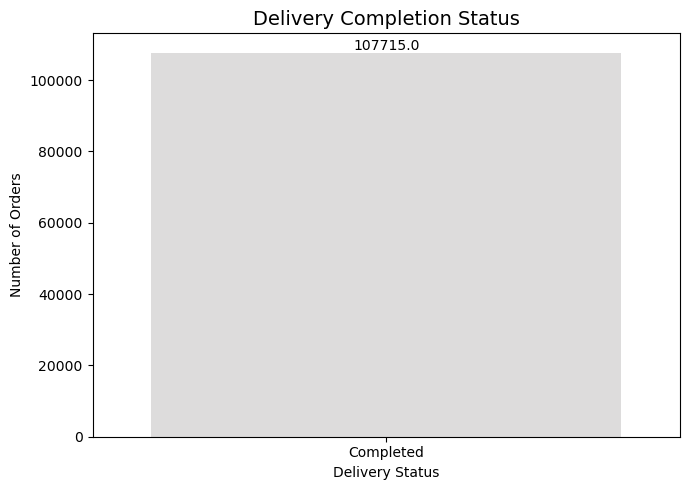

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='delivery_status', palette='coolwarm', order=df['delivery_status'].value_counts().index)

plt.title('Delivery Completion Status', fontsize=14)
plt.xlabel('Delivery Status')
plt.ylabel('Number of Orders')

# Show count labels on bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### SLA vislation vs Review Score

Review Score Imputation Based on SLA Violation

- Some `review_score` values are missing, likely because customers did not leave a review. 
- Rather than imputing with the global mode (which could bias the results), i use the mode of review scores within each `sla_violation` group. 
  
  This preserves the context:

- Customers with delayed deliveries may tend to leave lower scores
- Customers with on-time or early deliveries may be more satisfied

- This grouping ensures a more realistic reflection of customer satisfaction.

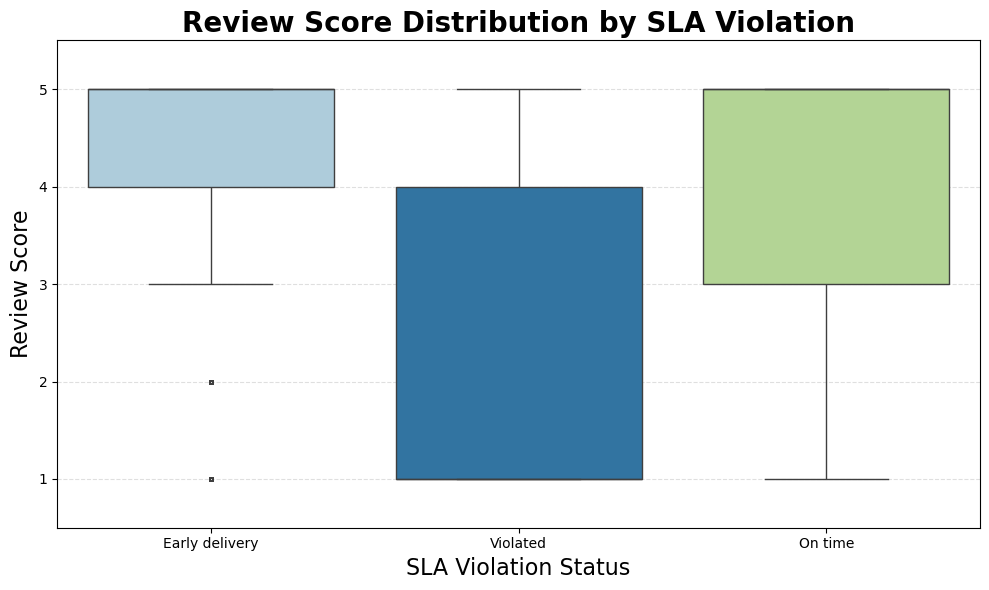

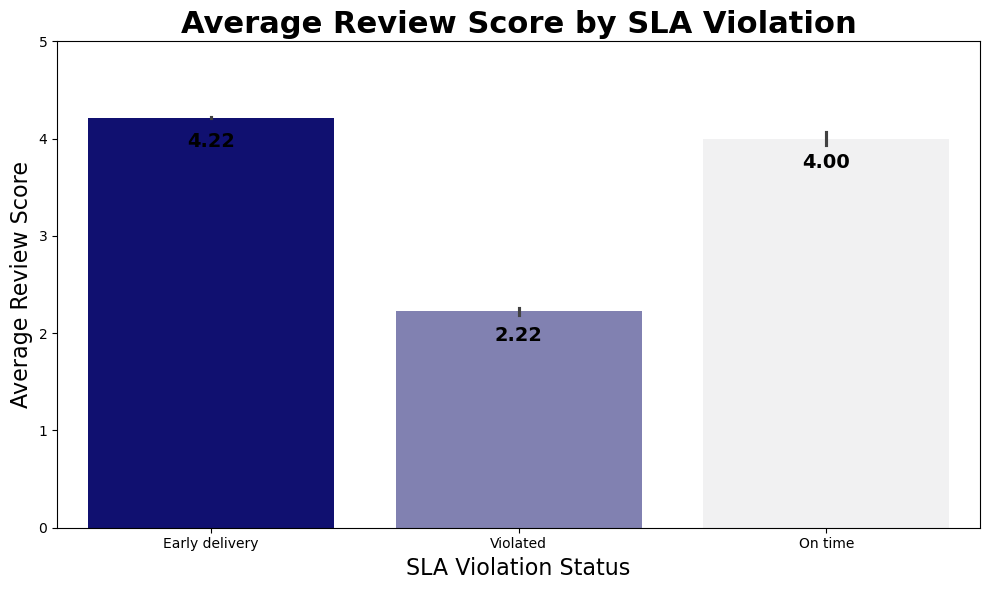

In [20]:
# Box Plot
plt.figure(figsize=(10, 6))
ax1 = sns.boxplot(
    data=df,
    x='sla_violation',
    y='review_score',
    palette=['#A6CEE3', '#1F78B4', '#B2DF8A'],  # 차분한 파스텔톤
    flierprops=dict(marker='.', markersize=5, color='gray', alpha=0.5)  # 아웃라이어 점 스타일
)
ax1.set_title('Review Score Distribution by SLA Violation', fontsize=20, weight='bold')
ax1.set_xlabel('SLA Violation Status', fontsize=16)
ax1.set_ylabel('Review Score', fontsize=16)
ax1.set_ylim(0.5, 5.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Average score

plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    data=df,
    x='sla_violation',
    y='review_score',
    estimator='mean',
    palette=sns.light_palette("navy", reverse=True, n_colors=3)
)
ax2.set_title('Average Review Score by SLA Violation', fontsize=22, weight='bold')
ax2.set_xlabel('SLA Violation Status', fontsize=16)
ax2.set_ylabel('Average Review Score', fontsize=16)
ax2.set_ylim(0, 5)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.2f}', 
                 (p.get_x() + p.get_width() / 2, height - 0.15), 
                 ha='center', va='top', fontsize=14, fontweight='bold', color='black')
plt.tight_layout()
plt.show()

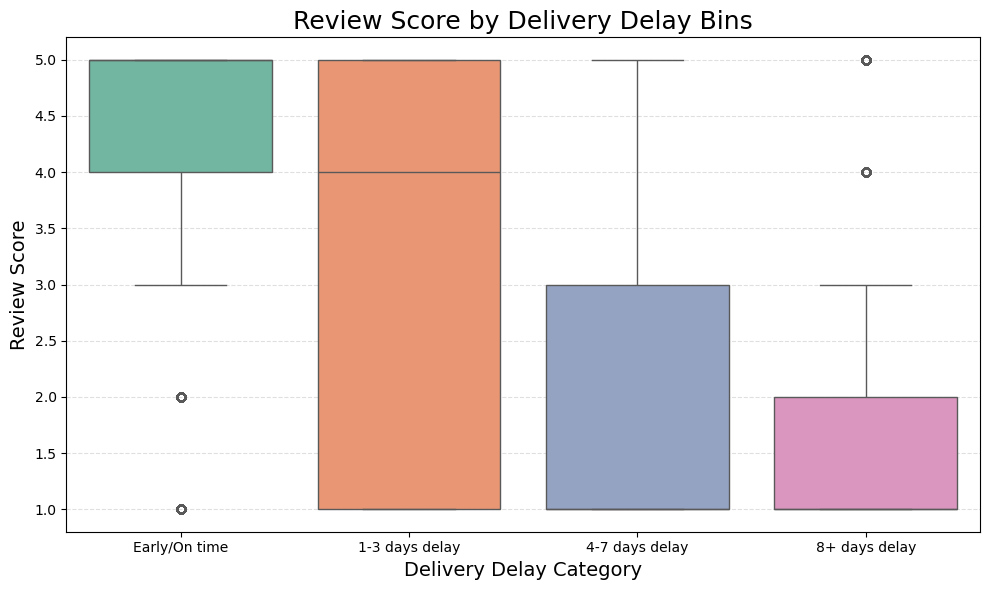

In [21]:
# Create bins
bins = [-10, 0, 3, 7, 30]
labels = ['Early/On time', '1-3 days delay', '4-7 days delay', '8+ days delay']
df['delay_bin'] = pd.cut(df['delivery_delay'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
delay_colors = ['#66C2A5', '#FC8D62', '#8DA0CB', '#E78AC3']
ax3 = sns.boxplot(data=df, x='delay_bin', y='review_score', palette=delay_colors)
ax3.set_title('Review Score by Delivery Delay Bins', fontsize=18)
ax3.set_xlabel('Delivery Delay Category', fontsize=14)
ax3.set_ylabel('Review Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Product Category vs Review Score

product_category_name_english
office_furniture            4.764706
perfumery                   4.711538
electronics                 4.677419
baby                        4.666667
garden_tools                4.666667
bed_bath_table              4.664894
furniture_decor             4.649682
computers_accessories       4.648855
health_beauty               4.645833
auto                        4.642857
sports_leisure              4.628788
watches_gifts               4.608696
housewares                  4.600000
toys                        4.596491
stationery                  4.577778
pet_shop                    4.571429
cool_stuff                  4.568966
fashion_bags_accessories    4.565217
telephony                   4.516854
Name: review_score, dtype: float64


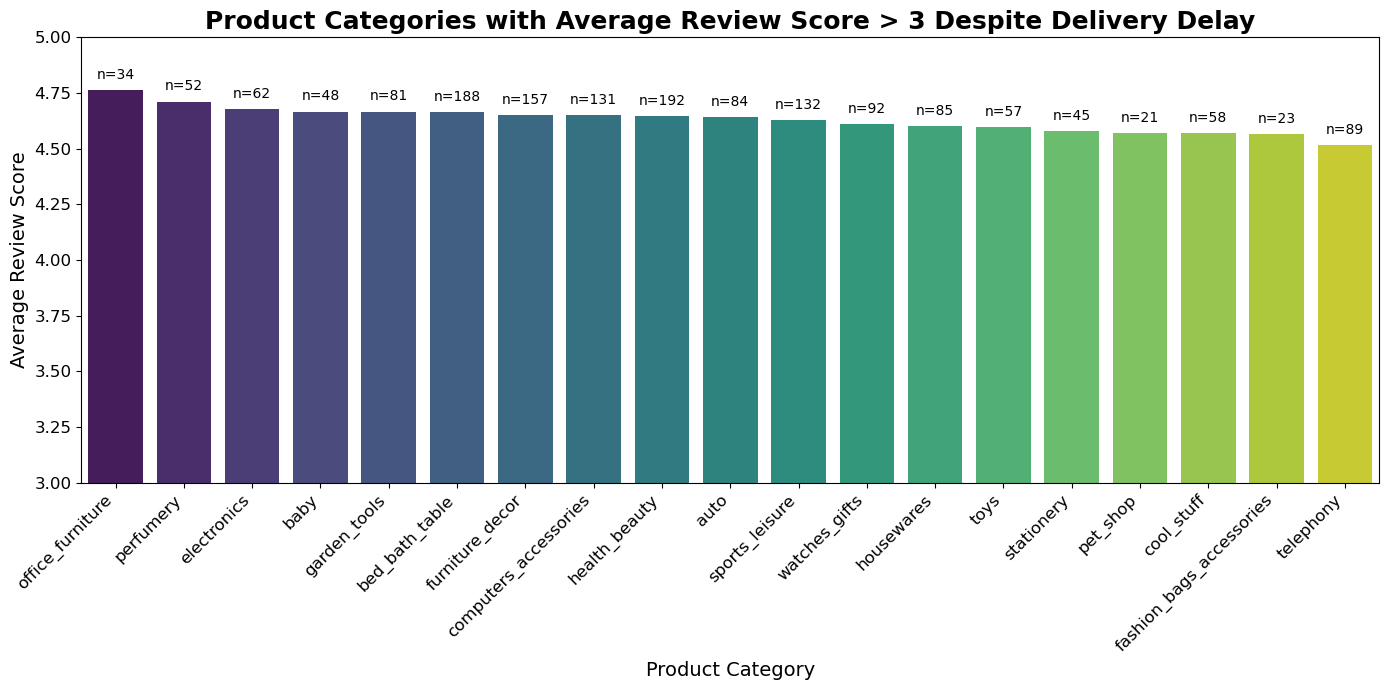

In [22]:
delayed_good_reviews = df[(df['sla_violation'] == 'Violated') & (df['review_score'] > 3)]

cat_avg_scores = delayed_good_reviews.groupby('product_category_name_english')['review_score'].mean()

review_counts = delayed_good_reviews.groupby('product_category_name_english')['review_score'].count()
good_cats = cat_avg_scores[(cat_avg_scores > 3) & (review_counts >= 20)].sort_values(ascending=False)

print(good_cats)

plt.figure(figsize=(14,7))
sns.barplot(x=good_cats.index, y=good_cats.values, palette='viridis')

plt.title('Product Categories with Average Review Score > 3 Despite Delivery Delay', fontsize=18, weight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Average Review Score', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(3, 5)

for i, cat in enumerate(good_cats.index):
    count = review_counts.loc[cat]
    plt.text(i, good_cats[cat] + 0.05, f'n={count}', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()



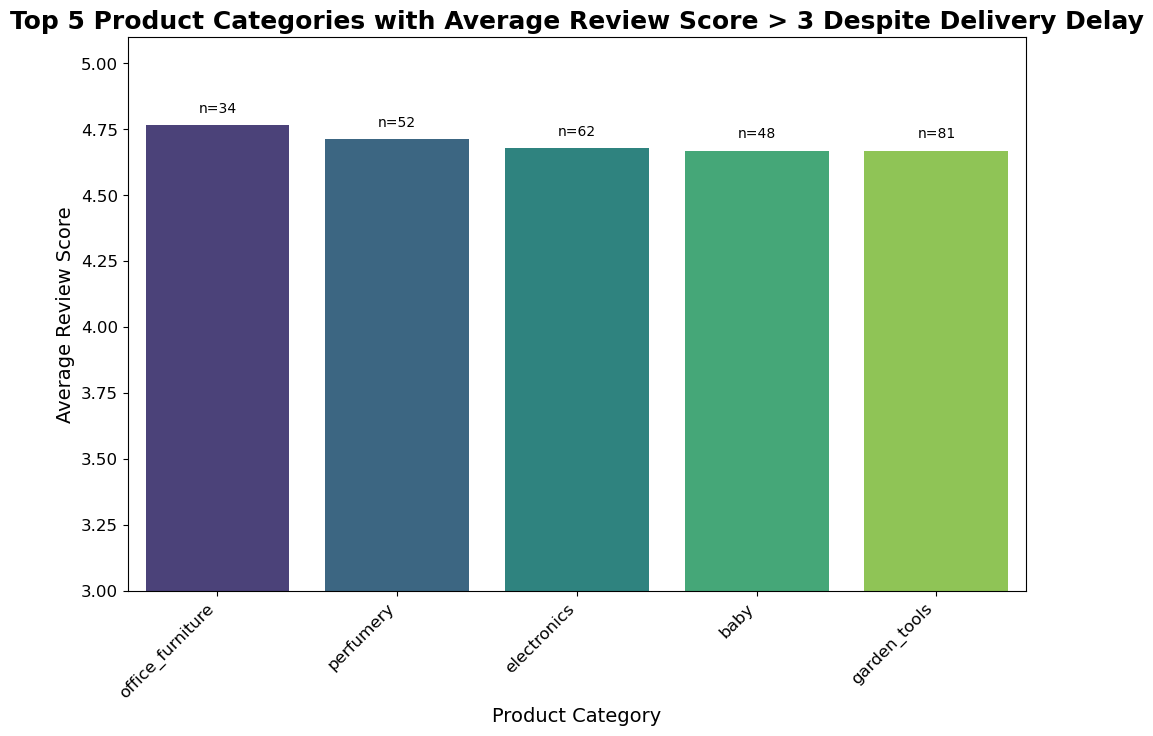

In [23]:
top5_cats = good_cats.head(5)

plt.figure(figsize=(10,8))
sns.barplot(x=top5_cats.index, y=top5_cats.values, palette='viridis')

plt.title('Top 5 Product Categories with Average Review Score > 3 Despite Delivery Delay', fontsize=18, weight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Average Review Score', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(3, 5.1)

for i, cat in enumerate(top5_cats.index):
    count = review_counts.loc[cat]
    plt.text(i, top5_cats[cat] + 0.05, f'n={count}', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


Observation:

- Customers in these 5 categories still rated their experiences highly even with delivery delays.
- All categories had at least 30+ reviews, so the findings are based on a reasonable sample size for each.

Insights & Interpretation

1. Perceived Product Value Trumps Delay

    - Customers buying items like electronics, baby products, and office furniture may prioritize product quality, functionality, or utility over prompt delivery.

    - Even when delayed, satisfaction remains high if the product meets or exceeds expectations.

2. Low Urgency or High Tolerance
    - Categories like garden tools or office furniture may not be as time-sensitive as daily essentials.

    - Users may anticipate longer delivery windows, especially for bulky or less common items, and are more forgiving if expectations are met in other areas.

3. Emotional/Personal Value Products
    - Perfumery and baby products often carry emotional weight or personal value.

    - A positive unboxing or product experience can offset the frustration of delays, especially if the item feels premium, well-packaged, or worth the wait.

4. Brand/Product Loyalty
    - Higher tolerance for delays may reflect strong brand preference or product desirability in these categories.

    - Customers might repurchase or recommend even if delivery isn't perfect, making these categories good candidates for loyalty programs.

Recommendations
    
- Maintain or improve product quality in these categories—it’s clearly driving customer satisfaction even during poor logistics.

- Consider offering small gestures (e.g., discounts, thank-you notes) to further reinforce satisfaction for delayed deliveries in these forgiving categories.

- Explore communication strategies: Proactively letting customers in these categories know about potential delays may further preserve their goodwill.

In [24]:
# Filter delayed orders
delayed_df = df[df['delivery_delay'] > 0]

# Group by category and calculate average review score
low_score_delayed = (
    delayed_df
    .groupby('product_category_name_english')['review_score']
    .mean()
    .reset_index()
    .query('review_score < 3')
    .sort_values(by='review_score')
)

# Display top 5 worst categories
print(low_score_delayed.head(5))


   product_category_name_english  review_score
51                         music           1.0
3          arts_and_craftmanship           1.0
32                       flowers           1.0
9                 books_imported           1.0
18     construction_tools_safety           1.2


### Price Ranges vs Delay

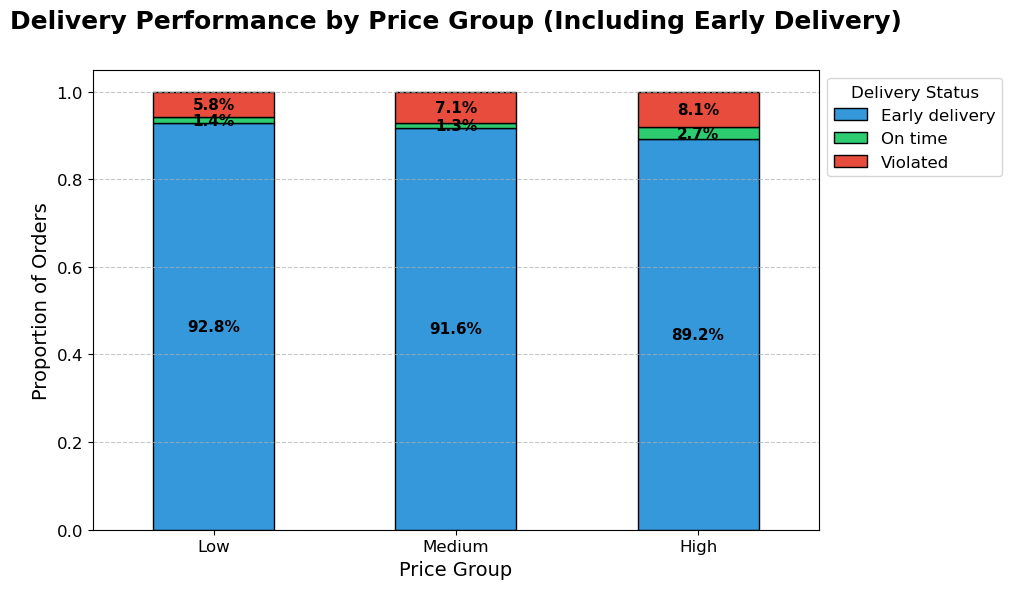

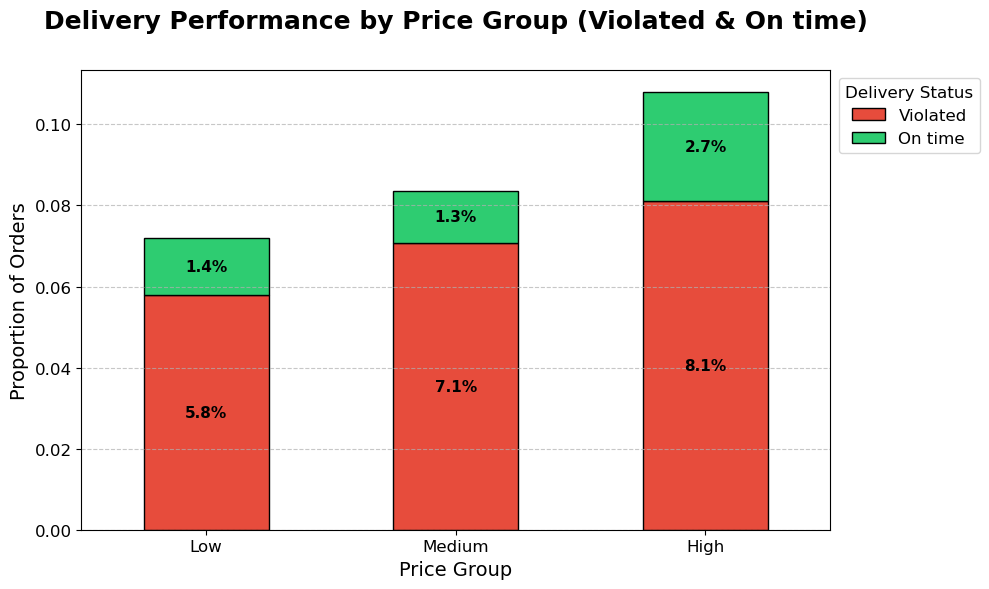

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Group prices
def group_price(price):
    if price < 50:
        return 'Low'
    elif 50 <= price < 2000:
        return 'Medium'
    else:
        return 'High'

df['price_group'] = df['price'].apply(group_price)

# 2a. Three-status data: Early delivery, On time, Violated
delivery_by_price_all = (
    df.groupby('price_group')['sla_violation']
      .value_counts(normalize=True)
      .unstack()
      .fillna(0)
)[['Early delivery', 'On time', 'Violated']].reindex(['Low', 'Medium', 'High'])

# 2b. Two-status data: Violated and On time only
delivery_by_price_two = (
    df.groupby('price_group')['sla_violation']
      .value_counts(normalize=True)
      .unstack()
      .fillna(0)
)[['Violated', 'On time']].reindex(['Low', 'Medium', 'High'])

# --- Plot 1: Early delivery, On time & Violated (FULL) ---

# Distinct colors: Early delivery (blue), On time (green), Violated (red)
custom_colors_all = ['#3498db', '#2ecc71', '#e74c3c']  # blue, green, red
ax1 = delivery_by_price_all.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_colors_all,
    edgecolor='black'
)

plt.title('Delivery Performance by Price Group (Including Early Delivery)', fontsize=18, pad=30, weight='bold')
plt.xlabel('Price Group', fontsize=14)
plt.ylabel('Proportion of Orders', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Delivery Status', title_fontsize=12, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, row in enumerate(delivery_by_price_all.values):
    cumulative = 0
    for j, val in enumerate(row):
        if val > 0:
            ax1.text(i, cumulative + val / 2, f'{val:.1%}', ha='center', va='center', fontsize=11, weight='bold')
            cumulative += val

plt.show()

# --- Plot 2: Violated & On time only ---

custom_colors_two = ['#e74c3c', '#2ecc71']  # red for Violated, green for On time
ax2 = delivery_by_price_two.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_colors_two,
    edgecolor='black'
)

plt.title('Delivery Performance by Price Group (Violated & On time)', fontsize=18, pad=30, weight='bold')
plt.xlabel('Price Group', fontsize=14)
plt.ylabel('Proportion of Orders', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Delivery Status', title_fontsize=12, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, row in enumerate(delivery_by_price_two.values):
    cumulative = 0
    for j, val in enumerate(row):
        if val > 0:
            ax2.text(i, cumulative + val / 2, f'{val:.1%}', ha='center', va='center', fontsize=11, weight='bold')
            cumulative += val

plt.show()


Observation:

- Early delivery accounts for more than 90% of all deliveries across all price groups.

- Among the remaining deliveries, the on-time rate is very low (around 1-3%) across price groups.

- The violation (delayed delivery) rate increases as price increases:

- Low price group: ~5.8% violated

- Medium price group: ~7.1% violated

- High price group: ~8.1% violated

- The high price group has the highest violation rate but also a slightly higher on-time delivery rate (~2.7%) compared to others.

Insights:

- The majority of deliveries arrive earlier than expected, which is positive and suggests some buffer in estimated delivery times.

- However, when delays do occur, they are more frequent in higher-priced product categories, indicating potential logistical challenges or handling complexity.

- The consistently low on-time delivery percentages suggest that the SLA target dates might be conservative or that the delivery process prioritizes early delivery over strict on-time precision.

Recommendations
- Maintain and leverage the strong early delivery performance as a competitive advantage.

- Focus on reducing late deliveries, especially for medium and high-priced products, where customer expectations may be higher.

- Review and possibly adjust estimated delivery dates to better reflect realistic delivery times and improve on-time metrics.

- Enhance logistics and handling processes for higher-priced products to reduce delay risks.

- Improve customer communication to clarify delivery expectations and provide transparency, particularly when delays are possible.

### User Behaviour patterns (Repeat customers, sessions)
- explore impact of multiple delivereis or repeat orders on satisfaction

In [26]:
# Count total orders per customer
customer_order_counts = df.groupby('customer_id')['order_id'].nunique().reset_index()
customer_order_counts.columns = ['customer_id', 'order_count']

# Merge back to main df
df = df.merge(customer_order_counts, on='customer_id', how='left')
print(customer_order_counts.value_counts().sort_index())

# Label customers as repeat or one-time
df['repeat_customer'] = np.where(df['order_count'] > 1, 'Repeat', 'One-time')

# Average review score by repeat vs one-time
avg_score_by_repeat = df.groupby('repeat_customer')['review_score'].mean()
print(avg_score_by_repeat)


customer_id                       order_count
00012a2ce6f8dcda20d059ce98491703  1              1
000161a058600d5901f007fab4c27140  1              1
0001fd6190edaaf884bcaf3d49edf079  1              1
0002414f95344307404f0ace7a26f1d5  1              1
000379cdec625522490c315e70c7a9fb  1              1
                                                ..
fffcb937e9dd47a13f05ecb8290f4d3e  1              1
fffecc9f79fd8c764f843e9951b11341  1              1
fffeda5b6d849fbd39689bb92087f431  1              1
ffff42319e9b2d713724ae527742af25  1              1
ffffa3172527f765de70084a7e53aae8  1              1
Name: count, Length: 93763, dtype: int64
repeat_customer
One-time    4.081641
Name: review_score, dtype: float64


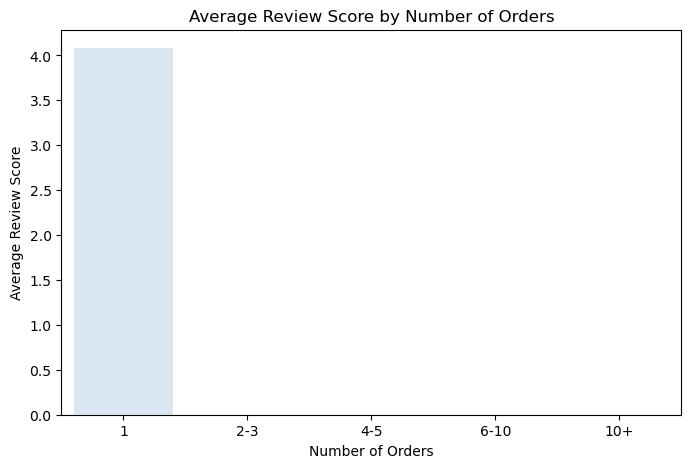

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate average review by order_count buckets
df['order_count_group'] = pd.cut(df['order_count'], bins=[0,1,3,5,10,100], labels=['1','2-3','4-5','6-10','10+'])

avg_score_by_order_count = df.groupby('order_count_group')['review_score'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='order_count_group', y='review_score', data=avg_score_by_order_count, palette='Blues')
plt.title('Average Review Score by Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Average Review Score')
plt.show()


- No repeat orders in your dataset — each customer has placed exactly one order.

- Your dataset probably represents either:

- A snapshot of first-time orders,

- Or covers a very short time frame where no customer has ordered twice yet,

- Or your data only tracks one order per customer (e.g., first purchase only).



### Delivery delays over time (by week/month) - decreasing? increasing?

In [28]:
# Make sure your date column is in datetime format (replace with your date column)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Day of week or month effects
df['purchase_dow'] = df['order_purchase_timestamp'].dt.dayofweek  # 0 = Monday
df['purchase_month'] = df['order_purchase_timestamp'].dt.month


In [29]:
# Delivery delay flag (True if violated)
df['is_violated'] = df['sla_violation'] == 'Violated'

# Group by week and calculate violation rate
weekly_delay_rate = df.groupby('purchase_dow')['is_violated'].mean()

# Group by month and calculate violation rate
monthly_delay_rate = df.groupby('purchase_month')['is_violated'].mean()


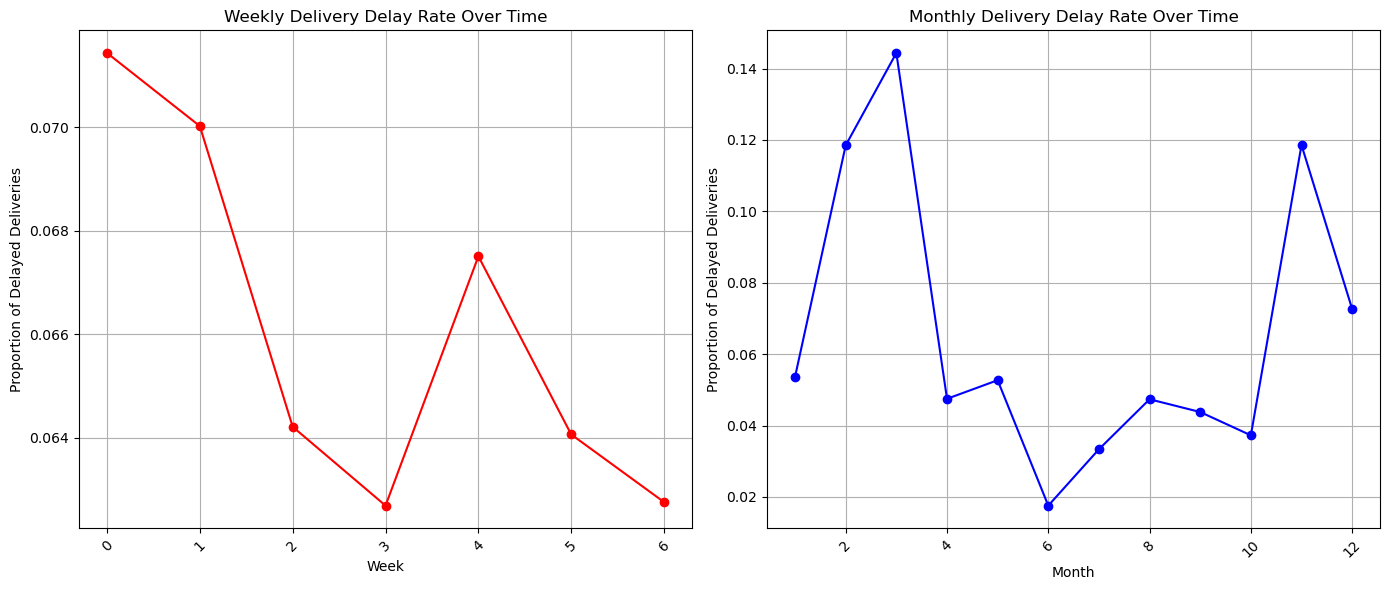

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Weekly plot
plt.subplot(1, 2, 1)
weekly_delay_rate.plot(marker='o', color='red')
plt.title('Weekly Delivery Delay Rate Over Time')
plt.xlabel('Week')
plt.ylabel('Proportion of Delayed Deliveries')
plt.xticks(rotation=45)
plt.grid(True)

# Monthly plot
plt.subplot(1, 2, 2)
monthly_delay_rate.plot(marker='o', color='blue')
plt.title('Monthly Delivery Delay Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Proportion of Delayed Deliveries')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


Holiday Seasons and Sales Events:

- Brazil’s biggest sales events (e.g., Black Friday — late November, which is around month 11, and Christmas season) cause order spikes, leading to delivery delays.

- Week 0-1 (start of the year) can see delays due to post-holiday backlogs or New Year holiday closures affecting logistics.

Local Brazilian Holidays:

  - Brazilian holidays like Carnival (usually in Feb or March, month 3) could affect delivery speed due to store closures and transport slowdowns.

  - Other holidays and local festivities also affect weeks/months with higher delays.

Weather and Regional Logistics:

  - Brazil is a large country with varying regional infrastructure. Weather disruptions (e.g., rainy season) may impact deliveries especially in certain months.

Operational Factors:

- Delays around month 3 and 11 may correspond to peak demand combined with logistics capacity constraints.

- Week 3 and month 6 being lowest could be more “normal” demand and smoother operations.

Recommendations for Your Analysis

  - Map delay peaks to local calendar events: Overlay major Brazilian holidays and sales events on your time series charts to confirm if peaks align with those dates.

  - Segment by region: Check if delays vary by customer state or city to see if regional factors play a role.

  - Explore product categories or seller effects: Some product types or sellers might experience more delays during peak periods.

  - Suggest proactive planning: For the business, recommend increasing logistics capacity, inventory buffers, or staffing ahead of known peak times (Black Friday, Carnival).

## Session Categorization/ Feature Engineering

In [31]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,delivery_delay,sla_violation,delay_bin,price_group,order_count,repeat_customer,order_count_group,purchase_dow,purchase_month,is_violated
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,-8.0,Early delivery,Early/On time,Low,1,One-time,1,0,10,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,-6.0,Early delivery,Early/On time,Medium,1,One-time,1,1,7,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,-18.0,Early delivery,NaN,Medium,1,One-time,1,2,8,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,-13.0,Early delivery,NaN,Low,1,One-time,1,5,11,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,-10.0,Early delivery,NaN,Low,1,One-time,1,1,2,False


In [32]:
# 2. Shipping time
df['shipping_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# 3. Approval delay
df['approval_delay'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600  # in hours

# 4. Total order value
df['total_order_value'] = df['price'] + df['freight_value']

# 5. Freight ratio
df['freight_ratio'] = df['freight_value'] / df['total_order_value']

# 6. Product volume (in cm^3)
df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# 7. Price per gram
df['price_per_gram'] = df['price'] / df['product_weight_g'].replace(0, np.nan)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107715 entries, 0 to 107714
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       107715 non-null  object        
 1   customer_id                    107715 non-null  object        
 2   order_status                   107715 non-null  object        
 3   order_purchase_timestamp       107715 non-null  datetime64[ns]
 4   order_approved_at              107715 non-null  datetime64[ns]
 5   order_delivered_carrier_date   107715 non-null  datetime64[ns]
 6   order_delivered_customer_date  107715 non-null  datetime64[ns]
 7   order_estimated_delivery_date  107715 non-null  datetime64[ns]
 8   customer_unique_id             107715 non-null  object        
 9   customer_zip_code_prefix       107715 non-null  int64         
 10  customer_city                  107715 non-null  object        
 11  

In [34]:
df.to_csv('data.csv', index=False)

In [35]:
drop_cols = [
    'delay_bin', 'order_count_group', 'order_count', 'repeat_customer', 'order_id', 
    'customer_id', 'customer_unique_id', 'product_id', 'seller_id', 'order_item_id', 
    'shipping_limit_date', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'product_name_length', 'product_description_length', 
    'product_photos_qty', 'seller_zip_code_prefix', 'customer_zip_code_prefix', 
    'order_status', 'order_purchase_timestamp', 'price_group', 'order_approved_at']

df = df.drop(columns=drop_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107715 entries, 0 to 107714
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_city                  107715 non-null  object 
 1   customer_state                 107715 non-null  object 
 2   price                          107715 non-null  float64
 3   freight_value                  107715 non-null  float64
 4   product_weight_g               107715 non-null  float64
 5   product_length_cm              107715 non-null  float64
 6   product_height_cm              107715 non-null  float64
 7   product_width_cm               107715 non-null  float64
 8   seller_city                    107715 non-null  object 
 9   seller_state                   107715 non-null  object 
 10  review_score                   107715 non-null  float64
 11  product_category_name_english  107715 non-null  object 
 12  delivery_status               

In [36]:
corr = df.select_dtypes(include=['number']).corr()
corr

,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,delivery_delay,purchase_dow,purchase_month,shipping_time,approval_delay,total_order_value,freight_ratio,product_volume_cm3,price_per_gram
price,1.000000,0.412621,0.339375,0.143896,0.222407,0.172762,0.001778,-0.002999,0.001772,0.001859,0.061703,0.019640,0.997129,-0.431587,0.299024,0.177368
freight_value,0.412621,1.000000,0.611821,0.304892,0.390301,0.320531,-0.034560,-0.038710,0.003128,0.005457,0.215390,0.034346,0.480412,0.105382,0.584772,-0.017612
product_weight_g,0.339375,0.611821,1.000000,0.459210,0.584175,0.504798,-0.029632,0.012352,-0.002351,-0.008957,0.086709,0.017577,0.377620,-0.122165,0.804785,-0.099827
product_length_cm,0.143896,0.304892,0.459210,1.000000,0.189564,0.532017,-0.021958,0.011655,-0.000151,-0.003357,0.069623,0.011143,0.163893,-0.104891,0.539610,-0.112605
product_height_cm,0.222407,0.390301,0.584175,0.189564,1.000000,0.276121,-0.025117,-0.000552,-0.000211,0.013387,0.068038,0.012544,0.246585,-0.122247,0.723925,-0.075515
product_width_cm,0.172762,0.320531,0.504798,0.532017,0.276121,1.000000,-0.012975,0.001912,0.003982,0.003752,0.040161,0.003460,0.192985,-0.126453,0.622831,-0.094749
review_score,0.001778,-0.034560,-0.029632,-0.021958,-0.025117,-0.012975,1.000000,-0.238176,-0.010284,0.031452,-0.311444,-0.025262,-0.001161,-0.035785,-0.027494,0.002148
delivery_delay,-0.002999,-0.038710,0.012352,0.011655,-0.000552,0.001912,-0.238176,1.000000,-0.030698,0.026363,0.596427,0.051645,-0.006105,-0.034980,0.013422,-0.002549
purchase_dow,0.001772,0.003128,-0.002351,-0.000151,-0.000211,0.003982,-0.010284,-0.030698,1.000000,0.024482,0.028603,0.063989,0.001966,0.010681,-0.000913,0.004016
purchase_month,0.001859,0.005457,-0.008957,-0.003357,0.013387,0.003752,0.031452,0.026363,0.024482,1.000000,-0.057524,0.009047,0.002244,-0.009848,0.002075,-0.005482


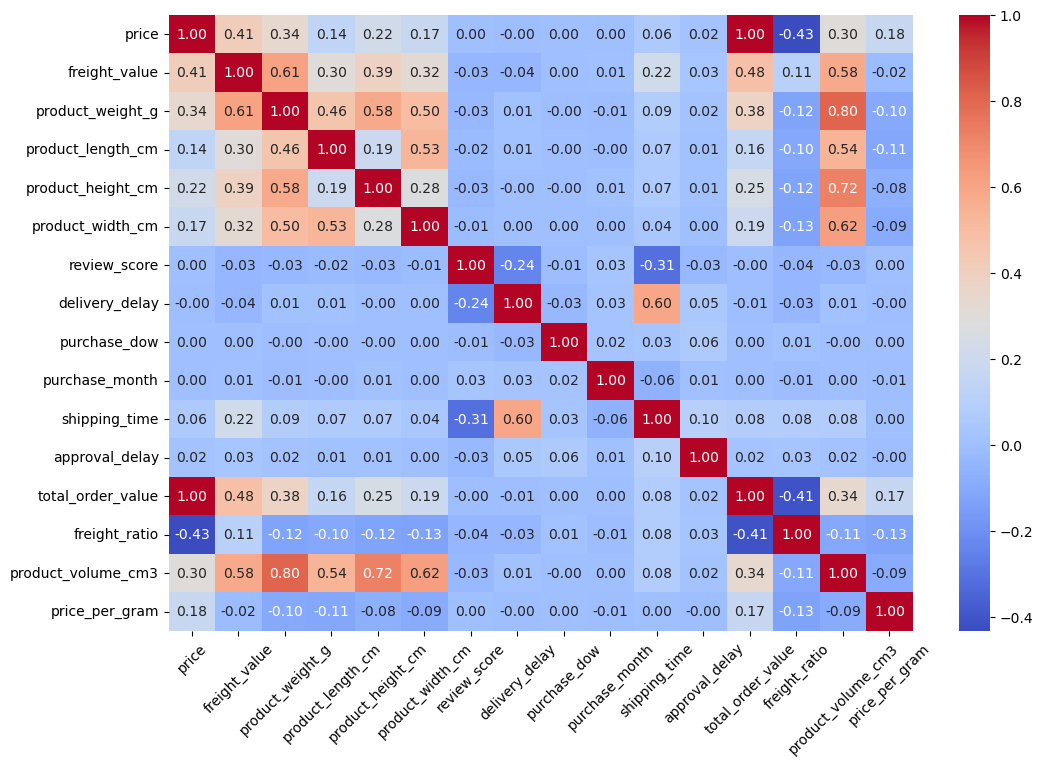

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.show()

In [38]:
review_corr = corr['review_score'].sort_values(ascending=False)
review_corr[1:]

purchase_month        0.031452
price_per_gram        0.002148
price                 0.001778
total_order_value    -0.001161
purchase_dow         -0.010284
product_width_cm     -0.012975
product_length_cm    -0.021958
product_height_cm    -0.025117
approval_delay       -0.025262
product_volume_cm3   -0.027494
product_weight_g     -0.029632
freight_value        -0.034560
freight_ratio        -0.035785
delivery_delay       -0.238176
shipping_time        -0.311444
Name: review_score, dtype: float64

Observation: Delivery delay is clearly the most influential factor on review scores.

In [39]:
from sklearn.preprocessing import LabelEncoder

# One-hot encode low-cardinality categoricals
one_hot_cols = ['customer_state', 'seller_state', 'delivery_status', 'sla_violation']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Label encode high-cardinality categoricals
label_cols = ['customer_city', 'seller_city', 'product_category_name_english']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])


## Rnadom Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=['review_score'])
y = df['review_score']

# For regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = ['price', 'freight_value',
    'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm', 'delivery_delay']

scaler = RobustScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [41]:
from sklearn.metrics import accuracy_score

y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Confusion Matrix (Train)
print(f"\nConfusion Matrix (Train):\n {confusion_matrix(y_train, y_train_pred)}")

# Confusion Matrix (Test)
print(f"\nConfusion Matrix (Test):\n {confusion_matrix(y_test, y_test_pred)}")

# Classification Report (Train)
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Classification Report (Test)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 1.00
Test Accuracy: 0.67

Confusion Matrix (Train):
 [[ 9873    12    10     5     0]
 [    0  2857     1     0     0]
 [    2     8  7198     0     1]
 [   13     7    11 16413     1]
 [   28     8    15    43 49666]]

Confusion Matrix (Test):
 [[ 1301     9     9    21  1131]
 [  117   156     4     6   449]
 [  105     4   300    16  1415]
 [   83     2    11   600  3428]
 [  155     8    15   129 12069]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      9900
         2.0       0.99      1.00      0.99      2858
         3.0       0.99      1.00      1.00      7209
         4.0       1.00      1.00      1.00     16445
         5.0       1.00      1.00      1.00     49760

    accuracy                           1.00     86172
   macro avg       1.00      1.00      1.00     86172
weighted avg       1.00      1.00      1.00     86172


Classification Report (Test):
              precis

In [42]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, scoring='f1_weighted')
rs.fit(X_train_scaled, y_train)
print(rs.best_params_)
best_rf = rs.best_estimator_


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [43]:
from sklearn.metrics import accuracy_score

y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Confusion Matrix (Train)
print(f"\nConfusion Matrix (Train):\n {confusion_matrix(y_train, y_train_pred)}")

# Confusion Matrix (Test)
print(f"\nConfusion Matrix (Test):\n {confusion_matrix(y_test, y_test_pred)}")

# Classification Report (Train)
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Classification Report (Test)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.97
Test Accuracy: 0.65

Confusion Matrix (Train):
 [[ 9810    14    20     8    48]
 [   10  2848     0     0     0]
 [  264    13  6927     0     5]
 [  348    21    26 15938   112]
 [  824    51   152   262 48471]]

Confusion Matrix (Test):
 [[ 1360    12    35    79   985]
 [  136   162    16    38   380]
 [  152     5   339   117  1227]
 [  169    11    78   803  3063]
 [  281    15   139   589 11352]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       0.87      0.99      0.93      9900
         2.0       0.97      1.00      0.98      2858
         3.0       0.97      0.96      0.97      7209
         4.0       0.98      0.97      0.98     16445
         5.0       1.00      0.97      0.99     49760

    accuracy                           0.97     86172
   macro avg       0.96      0.98      0.97     86172
weighted avg       0.98      0.97      0.98     86172


Classification Report (Test):
              precis

            Feature  Importance
14   approval_delay    0.069970
9    delivery_delay    0.065399
16    freight_ratio    0.059527
13    shipping_time    0.058306
0     customer_city    0.057754
..              ...         ...
55  seller_state_PB    0.000025
52  seller_state_MS    0.000023
64  seller_state_SE    0.000015
54  seller_state_PA    0.000015
57  seller_state_PI    0.000011

[68 rows x 2 columns]


<Figure size 1400x2000 with 0 Axes>

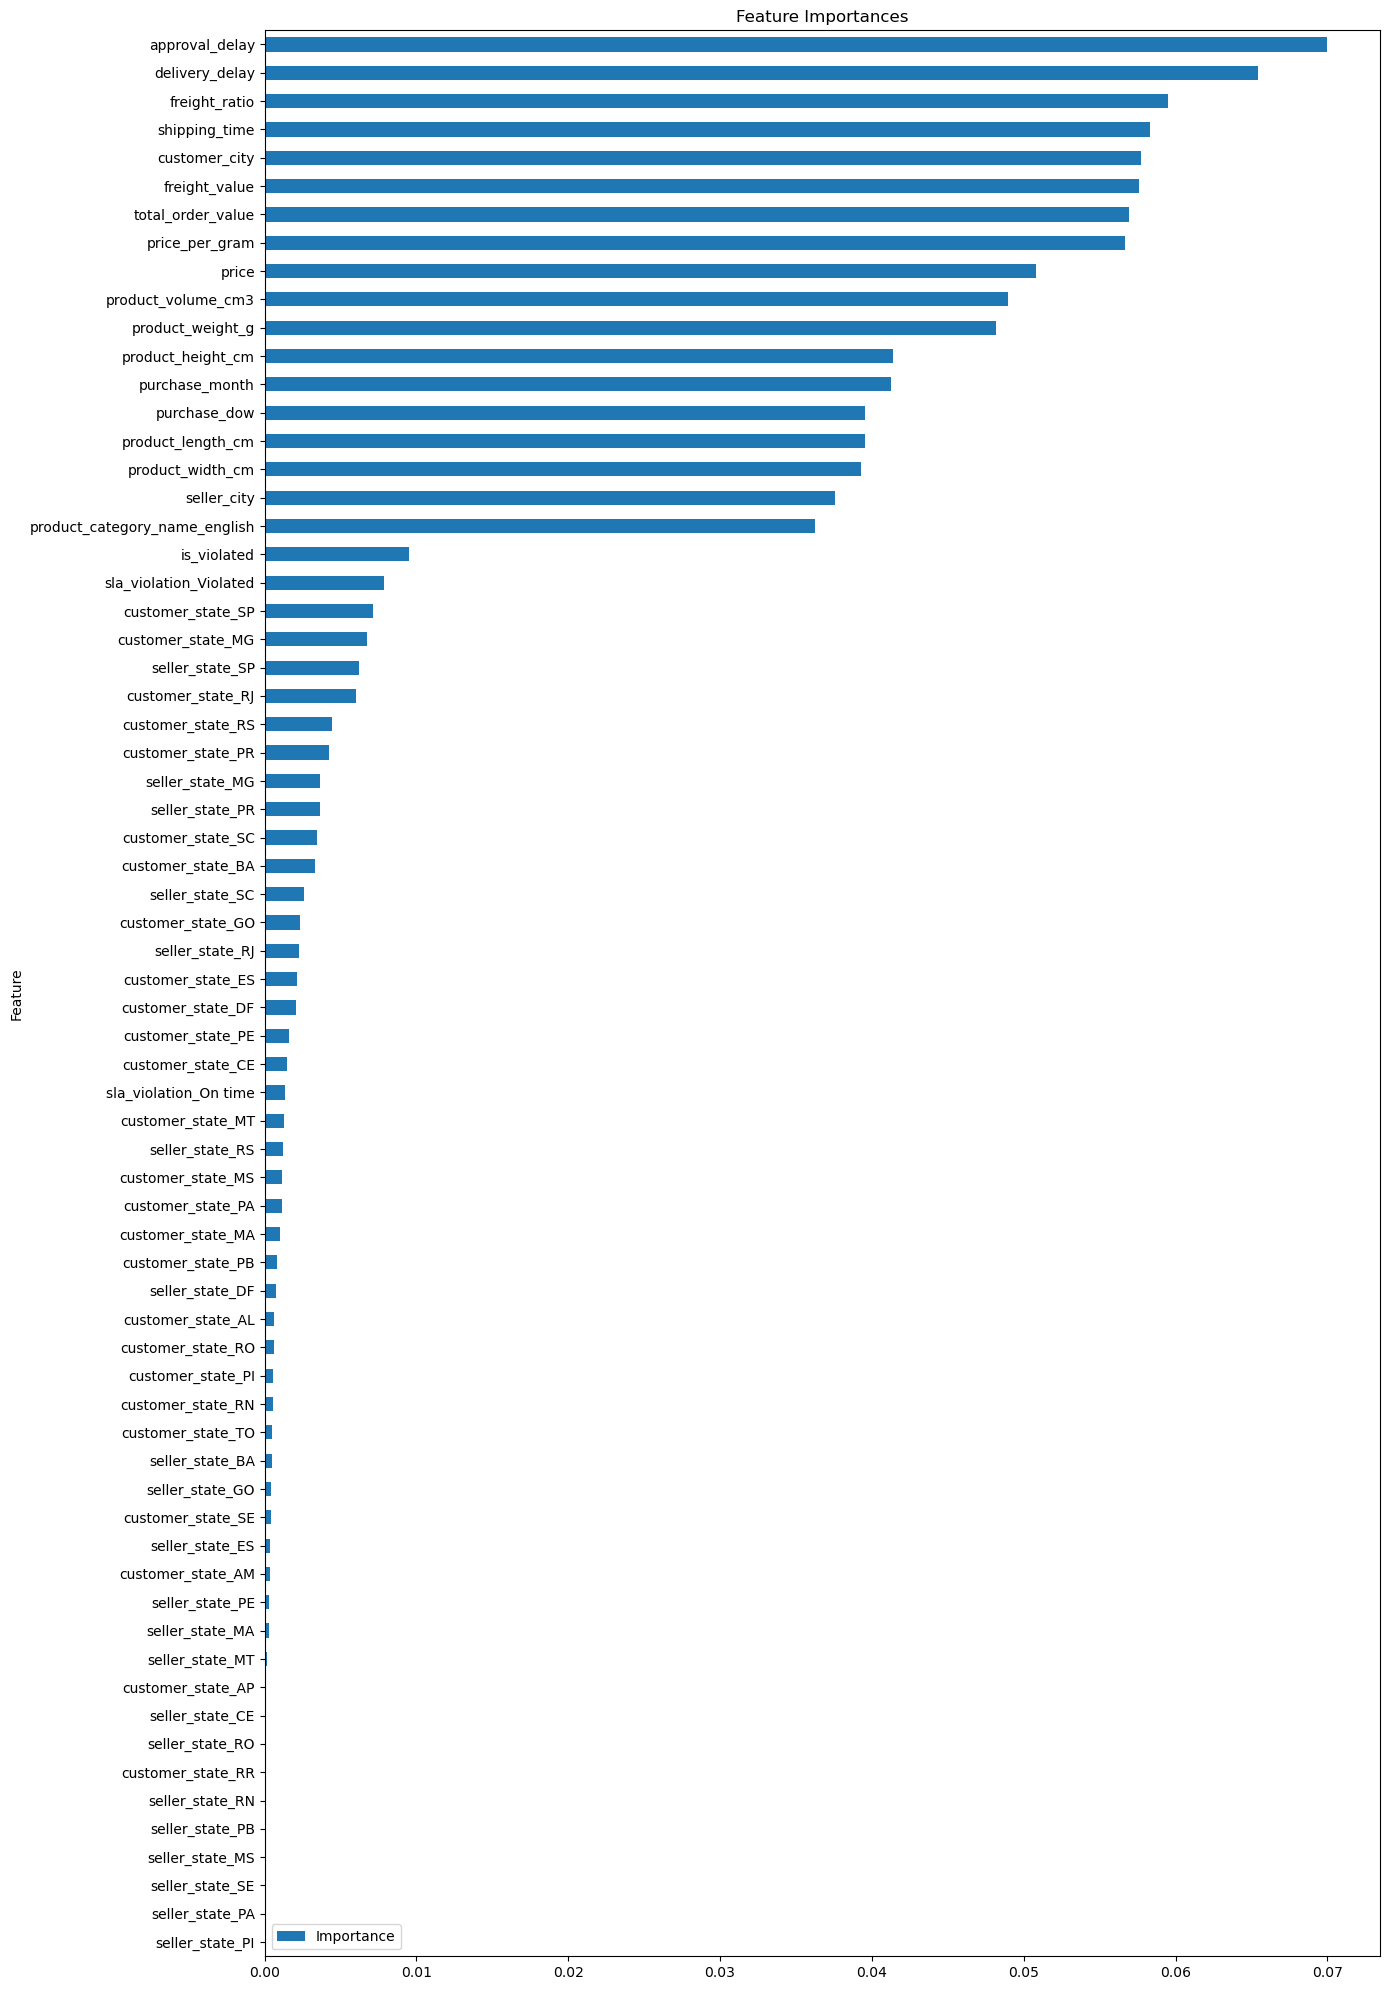

In [44]:
importances = rf.feature_importances_
feat_names = X_train_scaled.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feat_imp_df)

plt.figure(figsize=(14, 20))
feat_imp_df.plot(kind='barh', x='Feature', y='Importance', figsize=(14, 20), title='Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()  
plt.show()


In [45]:
# Assuming feat_imp_df has columns ['feature', 'importance']
low_importance = feat_imp_df[feat_imp_df['Importance'] < 0.0001]['Feature'].tolist()

X_train_reduced = X_train_scaled.drop(columns=low_importance)
X_test_reduced = X_test_scaled.drop(columns=low_importance)

In [46]:
best_rf_2 = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    bootstrap=True,
    class_weight='balanced'
)

best_rf_2.fit(X_train_reduced, y_train)

y_train_pred = best_rf_2.predict(X_train_reduced)
y_test_pred = best_rf_2.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Confusion Matrix (Train)
print(f"\nConfusion Matrix (Train):\n {confusion_matrix(y_train, y_train_pred)}")

# Confusion Matrix (Test)
print(f"\nConfusion Matrix (Test):\n {confusion_matrix(y_test, y_test_pred)}")

# Classification Report (Train)
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Classification Report (Test)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.99
Test Accuracy: 0.67

Confusion Matrix (Train):
 [[ 9873    12    11     4     0]
 [    0  2858     0     0     0]
 [    5     9  7195     0     0]
 [   89     9    12 16326     9]
 [  340    10    21    55 49334]]

Confusion Matrix (Test):
 [[ 1325    11    18    29  1088]
 [  122   157     8     9   436]
 [  122     5   305    34  1374]
 [  109     4    24   639  3348]
 [  207     6    36   210 11917]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       0.96      1.00      0.98      9900
         2.0       0.99      1.00      0.99      2858
         3.0       0.99      1.00      1.00      7209
         4.0       1.00      0.99      0.99     16445
         5.0       1.00      0.99      1.00     49760

    accuracy                           0.99     86172
   macro avg       0.99      1.00      0.99     86172
weighted avg       0.99      0.99      0.99     86172


Classification Report (Test):
              precis

Observation: 'best_rf_2' has a better performance.

## XGBoost

In [47]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels from [1.0, 2.0, 3.0, 4.0, 5.0] → [0, 1, 2, 3, 4]
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [48]:
num_classes = len(le.classes_)  # Should be 5

In [49]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_reduced, y_train_enc)

# Predict
y_train_pred = xgb_clf.predict(X_train_reduced)
y_test_pred = xgb_clf.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_enc, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_enc, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_enc, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))


Train Accuracy: 0.66
Test Accuracy: 0.61

Confusion Matrix (Train):
[[ 4311     0     2    47  5540]
 [  276   427     5    26  2124]
 [  350     2   755    73  6029]
 [  214     3     6  1758 14464]
 [  327     2     4    45 49382]]

Confusion Matrix (Test):
[[  850     5     5    24  1587]
 [  127    28     1    14   562]
 [   96     0    63    28  1653]
 [   78     0     4   171  3871]
 [  136     3    14    88 12135]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       0.79      0.44      0.56      9900
         2.0       0.98      0.15      0.26      2858
         3.0       0.98      0.10      0.19      7209
         4.0       0.90      0.11      0.19     16445
         5.0       0.64      0.99      0.78     49760

    accuracy                           0.66     86172
   macro avg       0.86      0.36      0.40     86172
weighted avg       0.74      0.66      0.57     86172


Classification Report (Test):
              precisio

## SMOTE

In [50]:
X_train_reduced['price_per_gram'].fillna(X_train_scaled['price_per_gram'].median(), inplace=True)


In [51]:
from imblearn.over_sampling import SMOTE

X_train_bal, y_train_bal = SMOTE().fit_resample(X_train_reduced, y_train_enc)

In [52]:
xgb_clf_2 = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_clf_2.fit(X_train_bal, y_train_bal)

# Predict
y_train_pred = xgb_clf_2.predict(X_train_bal)
y_test_pred = xgb_clf_2.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_bal, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_bal, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))


Train Accuracy: 0.66
Test Accuracy: 0.60

Confusion Matrix (Train):
[[30542  3791  4154  4046  7227]
 [ 3762 36390  3265  3154  3189]
 [ 4111  4827 27594  5360  7868]
 [ 2198  3696  6657 21367 15842]
 [  936   208   402   954 47260]]

Confusion Matrix (Test):
[[  931    20    38    43  1439]
 [  153    52     7    24   496]
 [  139    19   114    63  1505]
 [  164    20    53   218  3669]
 [  280    59   104   331 11602]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       0.74      0.61      0.67     49760
         2.0       0.74      0.73      0.74     49760
         3.0       0.66      0.55      0.60     49760
         4.0       0.61      0.43      0.50     49760
         5.0       0.58      0.95      0.72     49760

    accuracy                           0.66    248800
   macro avg       0.67      0.66      0.65    248800
weighted avg       0.67      0.66      0.65    248800


Classification Report (Test):
              precisio

In [53]:
xgb_clf_3 = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    colsample_bytree=0.9779976597381381,
    learning_rate=0.22818159875692626,
    max_depth=7,
    n_estimators=299,
    subsample=0.8711331923216198
)

xgb_clf_3.fit(X_train_bal, y_train_bal)

# Predict
y_train_pred = xgb_clf_3.predict(X_train_bal)
y_test_pred = xgb_clf_3.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_bal, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_bal, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))


Train Accuracy: 0.86
Test Accuracy: 0.62

Confusion Matrix (Train):
[[41577   999  1750  1790  3644]
 [  485 46672   668   535  1400]
 [ 1314  1181 41061  1694  4510]
 [ 1074  1149  2486 35021 10030]
 [  404    46   109   276 48925]]

Confusion Matrix (Test):
[[ 1067    23    39    65  1277]
 [  133   102    10    20   467]
 [  135    13   170    70  1452]
 [  144    10    48   442  3480]
 [  242    38   100   390 11606]]

Classification Report (Train):
              precision    recall  f1-score   support

         1.0       0.93      0.84      0.88     49760
         2.0       0.93      0.94      0.94     49760
         3.0       0.89      0.83      0.86     49760
         4.0       0.89      0.70      0.79     49760
         5.0       0.71      0.98      0.83     49760

    accuracy                           0.86    248800
   macro avg       0.87      0.86      0.86    248800
weighted avg       0.87      0.86      0.86    248800


Classification Report (Test):
              precisio

Observation: 'xgb_clf_3' has a better performance.

## LightGBM

In [54]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    class_weight='balanced',  # helps with class imbalance
    random_state=42
)

lgbm.fit(X_train_bal, y_train_bal)

# Predict
y_train_pred = lgbm.predict(X_train_bal)
y_test_pred = lgbm.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_bal, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_bal, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3864
[LightGBM] [Info] Number of data points in the train set: 248800, number of used features: 58
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Train Accuracy: 0.70
Test Accuracy: 0.61

Confusion Matrix (Train):
[[32833  2628  4081  3840  6378]
 [ 2866 39212  2557  2528  2597]
 [ 3764  3645 30364  5081  6906]
 [ 2035  2785  5480 24328 15132]
 [  804   103   104   263 48486]]

Confusion Matrix (Test):
[[  952    11    17    21  1470]
 [ 

In [55]:
lgbm_2 = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=50,
    max_depth=-1,
    class_weight='balanced',  # helps with class imbalance
    random_state=42
)

lgbm_2.fit(X_train_bal, y_train_bal)

# Predict
y_train_pred = lgbm_2.predict(X_train_bal)
y_test_pred = lgbm_2.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_bal, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_bal, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3864
[LightGBM] [Info] Number of data points in the train set: 248800, number of used features: 58
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Train Accuracy: 0.75
Test Accuracy: 0.62

Confusion Matrix (Train):
[[35229  1915  3317  3648  5651]
 [ 1876 42098  1542  1940  2304]
 [ 3123  2502 33697  3909  6529]
 [ 1724  2111  4039 27445 14441]
 [  652    67    79   169 48793]]

Confusion Matrix (Test):
[[  988    12    17    30  1424]
 [ 

In [56]:
lgbm_3 = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=-1,
    class_weight='balanced',  # helps with class imbalance
    random_state=42
)

lgbm_3.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test_reduced, y_test_enc)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Predict
y_train_pred = lgbm_3.predict(X_train_bal)
y_test_pred = lgbm_3.predict(X_test_reduced)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_test_pred):.2f}")

# Confusion Matrices
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train_bal, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_enc, y_test_pred))

# Classification Reports
print("\nClassification Report (Train):")
print(classification_report(y_train_bal, y_train_pred, target_names=le.classes_.astype(str)))

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_.astype(str)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3864
[LightGBM] [Info] Number of data points in the train set: 248800, number of used features: 58
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 1.10652
Train Accuracy: 0.78
Test Accuracy: 0.62

Confusion Matrix (Train):
[[36504  1695  3041  3246  5274]
 [ 1503 43677  1166  1373  204

Observation: 'lgbm_2' has a better performance.

## ROC-AUC Curve

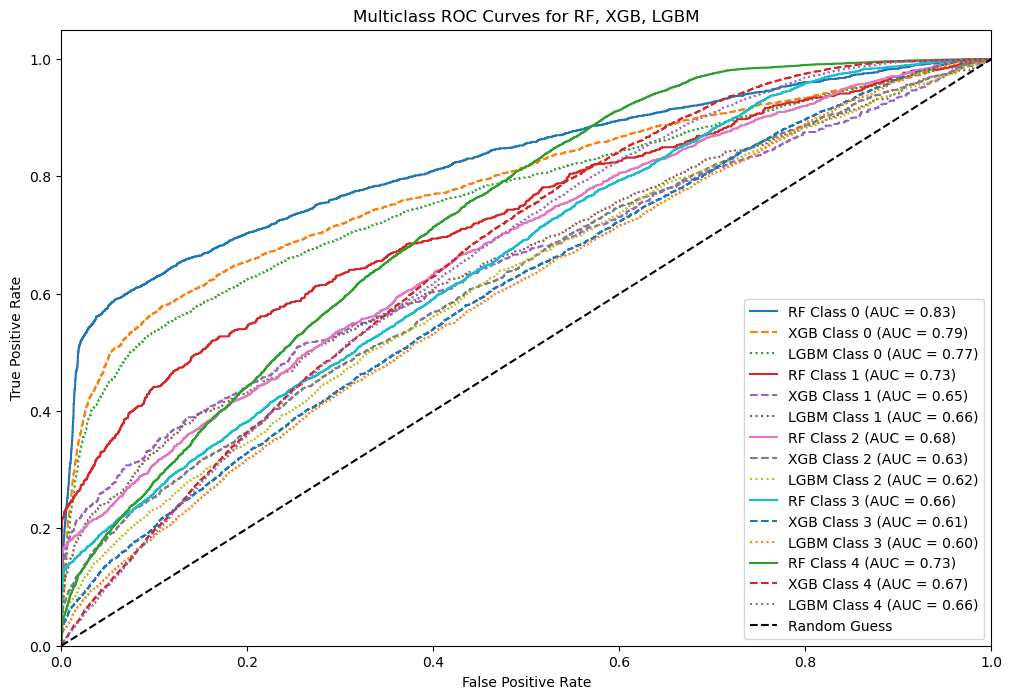

In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming your classes are labeled 0,1,...,num_classes-1
num_classes = len(np.unique(y_test_enc))

# Binarize the output labels for multiclass ROC
y_test_bin = label_binarize(y_test_enc, classes=range(num_classes))

# Predict probabilities for each model (shape: [n_samples, num_classes])
y_prob_rf = best_rf_2.predict_proba(X_test_reduced)
y_prob_xgb = xgb_clf_3.predict_proba(X_test_reduced)
y_prob_lgbm = lgbm_2.predict_proba(X_test_reduced)

# Plot ROC curves for each model and each class
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # RF
    fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'RF Class {i} (AUC = {roc_auc_rf:.2f})')

    # XGB
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    plt.plot(fpr_xgb, tpr_xgb, linestyle='--', label=f'XGB Class {i} (AUC = {roc_auc_xgb:.2f})')

    # LGBM
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test_bin[:, i], y_prob_lgbm[:, i])
    roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
    plt.plot(fpr_lgbm, tpr_lgbm, linestyle=':', label=f'LGBM Class {i} (AUC = {roc_auc_lgbm:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves for RF, XGB, LGBM')
plt.legend(loc='lower right')
plt.show()


| Class | RF Acc | XGB Acc | LGBM Acc |
|-------|--------|---------|----------|
| 0     | 0.82   | 0.79    | 0.77     |
| 1     | 0.72   | 0.66    | 0.67     |
| 2     | 0.68   | 0.62    | 0.62     |
| 3     | 0.66   | 0.61    | 0.60     |
| 4     | 0.73   | 0.67    | 0.66     |

---

| Model | Train Accuracy | Test Accuracy |
|-------|----------------|---------------|
| RF    | 0.99           | 0.67          |
| XGB   | 0.86           | 0.62          |
| LGBM  | 0.76           | 0.62          |


Observation: 
- Random Forest is your strongest model on the test set and per-class accuracy, but watch out for potential overfitting and instability with new data.

- XGBoost and LightGBM have slightly lower test performance but are probably more stable and less overfit.

## Insights

Challenges (Limitations)
- Ratings may reflect emotional bias, not just delivery
- Missing timestamps limit delay and SLA accuracy
- No long-term data or repeat orders
- Imbalanced review score classes hurt model performance


Future Improvements
- Add sentiment(text) & refund/return data.
- Tune model further and test algorithms
- Include data over time to track loyalty
- Consider weather or regional events
